## Solar Panel Fault Identification 
### Task Model
Applied Machine Learning Project <br>

Solar Panel Fault Detection using CNN

**Task description and objectives**
- The aim of this project is to create a Machine Learning Model that accurately predicts and shows what type of defect a solar panel has, based on pictures of it.
- It will be a supervised learning model. 
- Supervised: Predict type or presence of defect (classification) based on sensor/thermal/image data.


In [ ]:
# Libraries for deep learning
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import torchvision.utils as vutils

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

In [ ]:
# Libraries used throughout this script
import numpy as np
import matplotlib.pyplot as plt

ImportError: cannot import name '_functionalize_sync' from 'torch._utils' (/home/andreibaidoc/miniconda/envs/pytorch_env/lib/python3.10/site-packages/torch/_utils.py)

### Dataset extraction

In [17]:
import opendatasets as od
od.download('https://www.kaggle.com/datasets/pythonafroz/solar-panel-images')
data_dir = './solar-panel-images/Faulty_solar_panel'

Skipping, found downloaded files in ".\solar-panel-images" (use force=True to force download)


In [18]:
# Data transforms and splitting
img_size = 244
batch_size = 32

transform = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor(),
    # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # optional
])

# Full dataset with ImageFolder
full_dataset = datasets.ImageFolder(root=data_dir, transform=transform)
class_names = full_dataset.classes
print("Class labels:", class_names)

# Split into train/validation
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size

torch.manual_seed(42)
train_dataset, test_dataset = random_split(full_dataset, [train_size, val_size])

# DataLoaders
train_loader = DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True,
    num_workers=4, pin_memory=True
)
test_loader = DataLoader(
    test_dataset, batch_size=batch_size, shuffle=False,
    num_workers=4, pin_memory=True
)

Class labels: ['Bird-drop', 'Clean', 'Dusty', 'Electrical-damage', 'Physical-Damage', 'Snow-Covered']


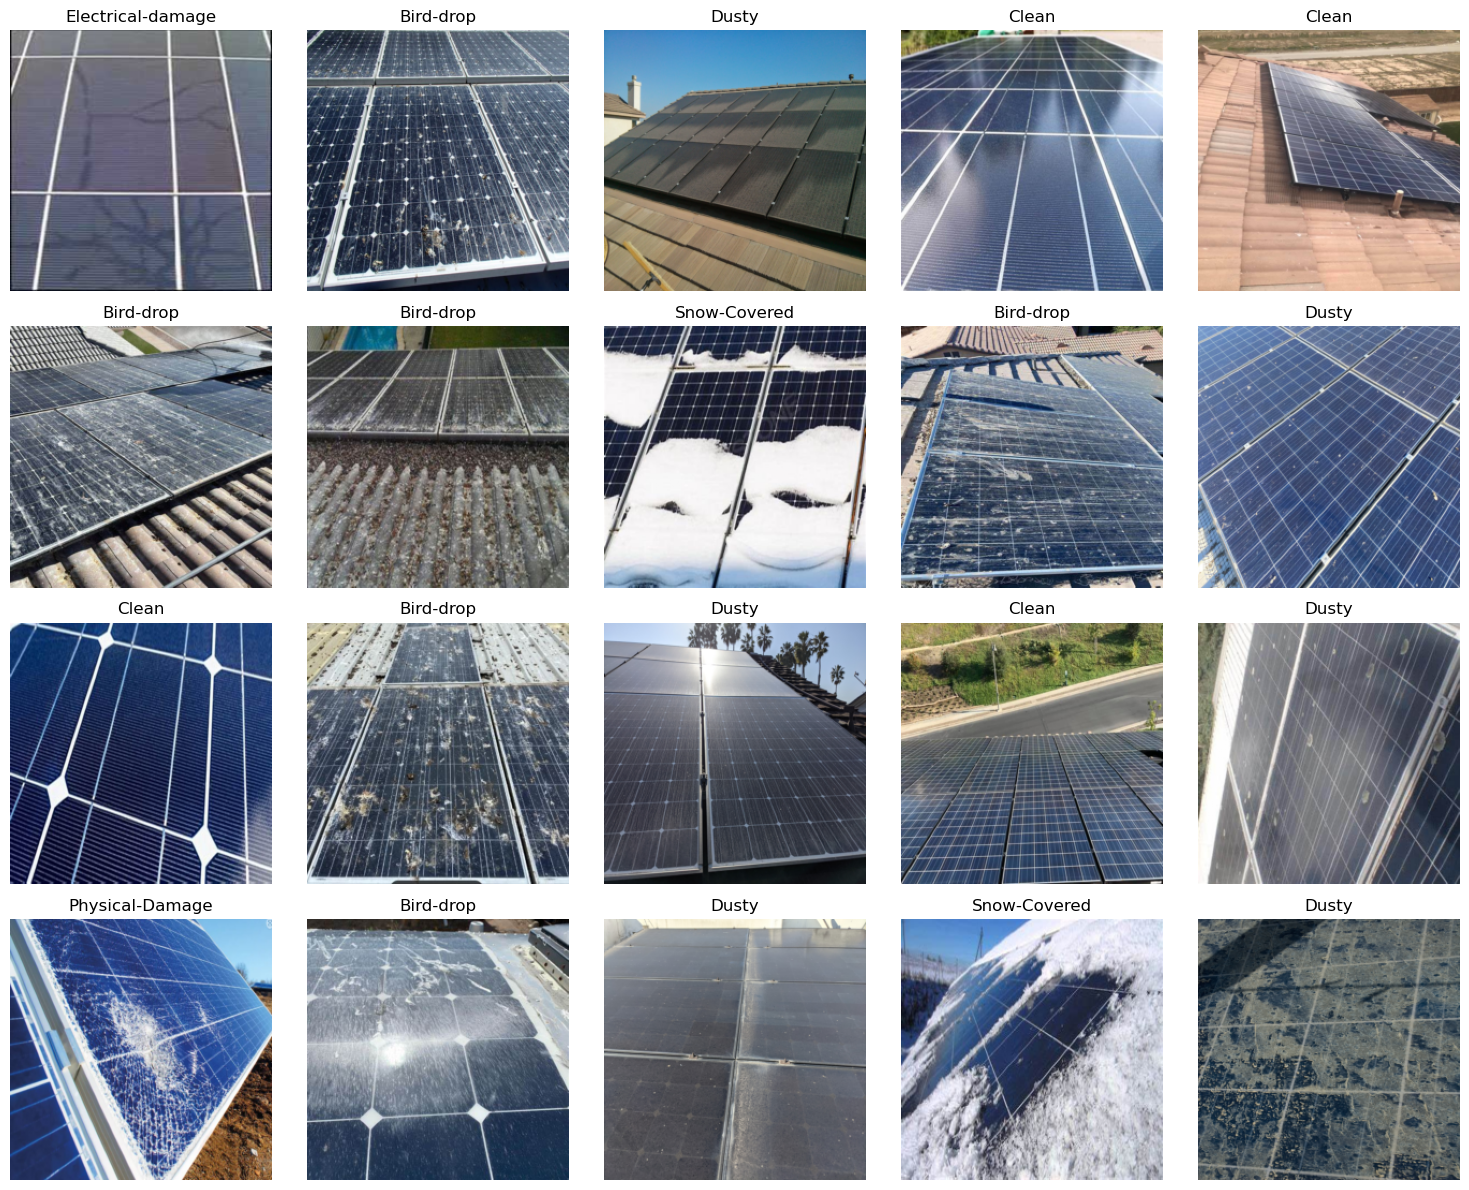

In [19]:
images, labels = next(iter(train_loader))
class_names = full_dataset.classes

plt.figure(figsize=(15, 12))
for i in range(20):  # Show 20 images
    ax = plt.subplot(4, 5, i + 1)
    img = images[i].cpu().permute(1, 2, 0).numpy()
    plt.imshow(img)
    plt.title(class_names[labels[i]])
    plt.axis('off')

plt.tight_layout()
plt.show()

### CNN implementation

In [20]:
# Define the CNN architecture
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 8, kernel_size=5)
        self.pool1 = nn.MaxPool2d(kernel_size=2)
        self.conv2 = nn.Conv2d(8, 16, kernel_size=5)
        self.pool2 = nn.MaxPool2d(kernel_size=2)
        self.adaptpool = nn.AdaptiveAvgPool2d((5,5))  # ensure flatten size = 16*5*5
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(16*5*5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, len(class_names))

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = self.pool1(x)
        x = torch.relu(self.conv2(x))
        x = self.pool2(x)
        x = self.adaptpool(x)
        x = self.flatten(x)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [21]:
# Initialize the network
model = SimpleCNN().to(device)
print(model)

SimpleCNN(
  (conv1): Conv2d(3, 8, kernel_size=(5, 5), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(8, 16, kernel_size=(5, 5), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (adaptpool): AdaptiveAvgPool2d(output_size=(5, 5))
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=6, bias=True)
)


In [22]:
# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [23]:
# Check for proper GPU support
# Check CUDA
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# sanity checks
print("CUDA available:", torch.cuda.is_available())
print("Model parameters live on:", next(model.parameters()).device)

Using device: cuda:0
CUDA available: True
Model parameters live on: cuda:0


In [ ]:
from tqdm.auto import tqdm

num_epochs = 20
for epoch in range(num_epochs):
    print(f"\n→ Starting epoch {epoch+1}/{num_epochs}")
    running_loss = 0.0

    # wrap the loader in tqdm so you get a live progress bar
    progbar = tqdm(train_loader, desc="Training", leave=False)
    for i, (inputs, labels) in enumerate(progbar, start=1):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        # update the tqdm bar with the latest average loss
        progbar.set_postfix(avg_loss=running_loss / i)

        # optional: still print every 50 steps if you like
        if i % 50 == 0:
            print(f"  Step {i}/{len(train_loader)}  loss: {running_loss / i:.4f}")

    epoch_loss = running_loss / len(train_loader)
    print(f"← Finished epoch {epoch+1}  avg loss: {epoch_loss:.4f}")


→ Starting epoch 1/100


← Finished epoch 1  avg loss: 1.7984

→ Starting epoch 2/100


← Finished epoch 2  avg loss: 1.7925

→ Starting epoch 3/100


← Finished epoch 3  avg loss: 1.7853

→ Starting epoch 4/100


← Finished epoch 4  avg loss: 1.7794

→ Starting epoch 5/100


← Finished epoch 5  avg loss: 1.7733

→ Starting epoch 6/100


← Finished epoch 6  avg loss: 1.7685

→ Starting epoch 7/100


← Finished epoch 7  avg loss: 1.7663

→ Starting epoch 8/100


← Finished epoch 8  avg loss: 1.7646

→ Starting epoch 9/100


← Finished epoch 9  avg loss: 1.7603

→ Starting epoch 10/100


← Finished epoch 10  avg loss: 1.7576

→ Starting epoch 11/100


← Finished epoch 11  avg loss: 1.7532

→ Starting epoch 12/100


← Finished epoch 12  avg loss: 1.7527

→ Starting epoch 13/100


← Finished epoch 13  avg loss: 1.7505

→ Starting epoch 14/100


← Finished epoch 14  avg loss: 1.7452

→ Starting epoch 15/100


← Finished epoch 15  avg loss: 1.7425

→ Starting epoch 16/100


← Finished epoch 16  avg loss: 1.7433

→ Starting epoch 17/100


← Finished epoch 17  avg loss: 1.7366

→ Starting epoch 18/100


← Finished epoch 18  avg loss: 1.7354

→ Starting epoch 19/100


← Finished epoch 19  avg loss: 1.7407

→ Starting epoch 20/100


← Finished epoch 20  avg loss: 1.7324

→ Starting epoch 21/100


← Finished epoch 21  avg loss: 1.7339

→ Starting epoch 22/100


← Finished epoch 22  avg loss: 1.7288

→ Starting epoch 23/100


← Finished epoch 23  avg loss: 1.7351

→ Starting epoch 24/100


← Finished epoch 24  avg loss: 1.7321

→ Starting epoch 25/100


← Finished epoch 25  avg loss: 1.7330

→ Starting epoch 26/100


← Finished epoch 26  avg loss: 1.7261

→ Starting epoch 27/100


← Finished epoch 27  avg loss: 1.7316

→ Starting epoch 28/100


← Finished epoch 28  avg loss: 1.7301

→ Starting epoch 29/100


← Finished epoch 29  avg loss: 1.7405

→ Starting epoch 30/100


← Finished epoch 30  avg loss: 1.7247

→ Starting epoch 31/100


← Finished epoch 31  avg loss: 1.7279

→ Starting epoch 32/100


← Finished epoch 32  avg loss: 1.7342

→ Starting epoch 33/100


← Finished epoch 33  avg loss: 1.7396

→ Starting epoch 34/100


← Finished epoch 34  avg loss: 1.7336

→ Starting epoch 35/100


← Finished epoch 35  avg loss: 1.7326

→ Starting epoch 36/100


← Finished epoch 36  avg loss: 1.7245

→ Starting epoch 37/100


← Finished epoch 37  avg loss: 1.7443

→ Starting epoch 38/100


← Finished epoch 38  avg loss: 1.7391

→ Starting epoch 39/100


← Finished epoch 39  avg loss: 1.7296

→ Starting epoch 40/100


← Finished epoch 40  avg loss: 1.7318

→ Starting epoch 41/100


← Finished epoch 41  avg loss: 1.7285

→ Starting epoch 42/100


← Finished epoch 42  avg loss: 1.7199

→ Starting epoch 43/100


← Finished epoch 43  avg loss: 1.7245

→ Starting epoch 44/100


← Finished epoch 44  avg loss: 1.7181

→ Starting epoch 45/100


← Finished epoch 45  avg loss: 1.7186

→ Starting epoch 46/100


← Finished epoch 46  avg loss: 1.7316

→ Starting epoch 47/100


← Finished epoch 47  avg loss: 1.7229

→ Starting epoch 48/100


← Finished epoch 48  avg loss: 1.7322

→ Starting epoch 49/100


← Finished epoch 49  avg loss: 1.7227

→ Starting epoch 50/100


← Finished epoch 50  avg loss: 1.7285

→ Starting epoch 51/100


← Finished epoch 51  avg loss: 1.7163

→ Starting epoch 52/100


← Finished epoch 52  avg loss: 1.7166

→ Starting epoch 53/100


← Finished epoch 53  avg loss: 1.7207

→ Starting epoch 54/100


← Finished epoch 54  avg loss: 1.7262

→ Starting epoch 55/100


← Finished epoch 55  avg loss: 1.7361

→ Starting epoch 56/100


← Finished epoch 56  avg loss: 1.7133

→ Starting epoch 57/100


← Finished epoch 57  avg loss: 1.7228

→ Starting epoch 58/100


← Finished epoch 58  avg loss: 1.7210

→ Starting epoch 59/100


← Finished epoch 59  avg loss: 1.7194

→ Starting epoch 60/100


← Finished epoch 60  avg loss: 1.7331

→ Starting epoch 61/100


← Finished epoch 61  avg loss: 1.7251

→ Starting epoch 62/100


← Finished epoch 62  avg loss: 1.7222

→ Starting epoch 63/100


← Finished epoch 63  avg loss: 1.7230

→ Starting epoch 64/100


← Finished epoch 64  avg loss: 1.7142

→ Starting epoch 65/100


← Finished epoch 65  avg loss: 1.7188

→ Starting epoch 66/100


← Finished epoch 66  avg loss: 1.7073

→ Starting epoch 67/100


← Finished epoch 67  avg loss: 1.7206

→ Starting epoch 68/100


← Finished epoch 68  avg loss: 1.7081

→ Starting epoch 69/100


← Finished epoch 69  avg loss: 1.7147

→ Starting epoch 70/100


← Finished epoch 70  avg loss: 1.7234

→ Starting epoch 71/100


← Finished epoch 71  avg loss: 1.7145

→ Starting epoch 72/100


← Finished epoch 72  avg loss: 1.7124

→ Starting epoch 73/100


← Finished epoch 73  avg loss: 1.7162

→ Starting epoch 74/100


← Finished epoch 74  avg loss: 1.7021

→ Starting epoch 75/100


← Finished epoch 75  avg loss: 1.7015

→ Starting epoch 76/100


← Finished epoch 76  avg loss: 1.6888

→ Starting epoch 77/100


← Finished epoch 77  avg loss: 1.6874

→ Starting epoch 78/100


← Finished epoch 78  avg loss: 1.6933

→ Starting epoch 79/100


← Finished epoch 79  avg loss: 1.7031

→ Starting epoch 80/100


← Finished epoch 80  avg loss: 1.6765

→ Starting epoch 81/100


← Finished epoch 81  avg loss: 1.6797

→ Starting epoch 82/100


← Finished epoch 82  avg loss: 1.6688

→ Starting epoch 83/100


← Finished epoch 83  avg loss: 1.6703

→ Starting epoch 84/100


← Finished epoch 84  avg loss: 1.6708

→ Starting epoch 85/100


← Finished epoch 85  avg loss: 1.6543

→ Starting epoch 86/100


← Finished epoch 86  avg loss: 1.6471

→ Starting epoch 87/100


← Finished epoch 87  avg loss: 1.6253

→ Starting epoch 88/100


← Finished epoch 88  avg loss: 1.6150

→ Starting epoch 89/100


← Finished epoch 89  avg loss: 1.6134

→ Starting epoch 90/100


← Finished epoch 90  avg loss: 1.5686

→ Starting epoch 91/100


← Finished epoch 91  avg loss: 1.5672

→ Starting epoch 92/100


← Finished epoch 92  avg loss: 1.5493

→ Starting epoch 93/100


← Finished epoch 93  avg loss: 1.5491

→ Starting epoch 94/100


← Finished epoch 94  avg loss: 1.4880

→ Starting epoch 95/100


← Finished epoch 95  avg loss: 1.4792

→ Starting epoch 96/100


← Finished epoch 96  avg loss: 1.4688

→ Starting epoch 97/100


← Finished epoch 97  avg loss: 1.4330

→ Starting epoch 98/100


← Finished epoch 98  avg loss: 1.4172

→ Starting epoch 99/100


← Finished epoch 99  avg loss: 1.4182

→ Starting epoch 100/100


← Finished epoch 100  avg loss: 1.4168


In [25]:
# Evaluation
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Test Accuracy: {100 * correct / total:.2f}%")

Test Accuracy: 45.20%


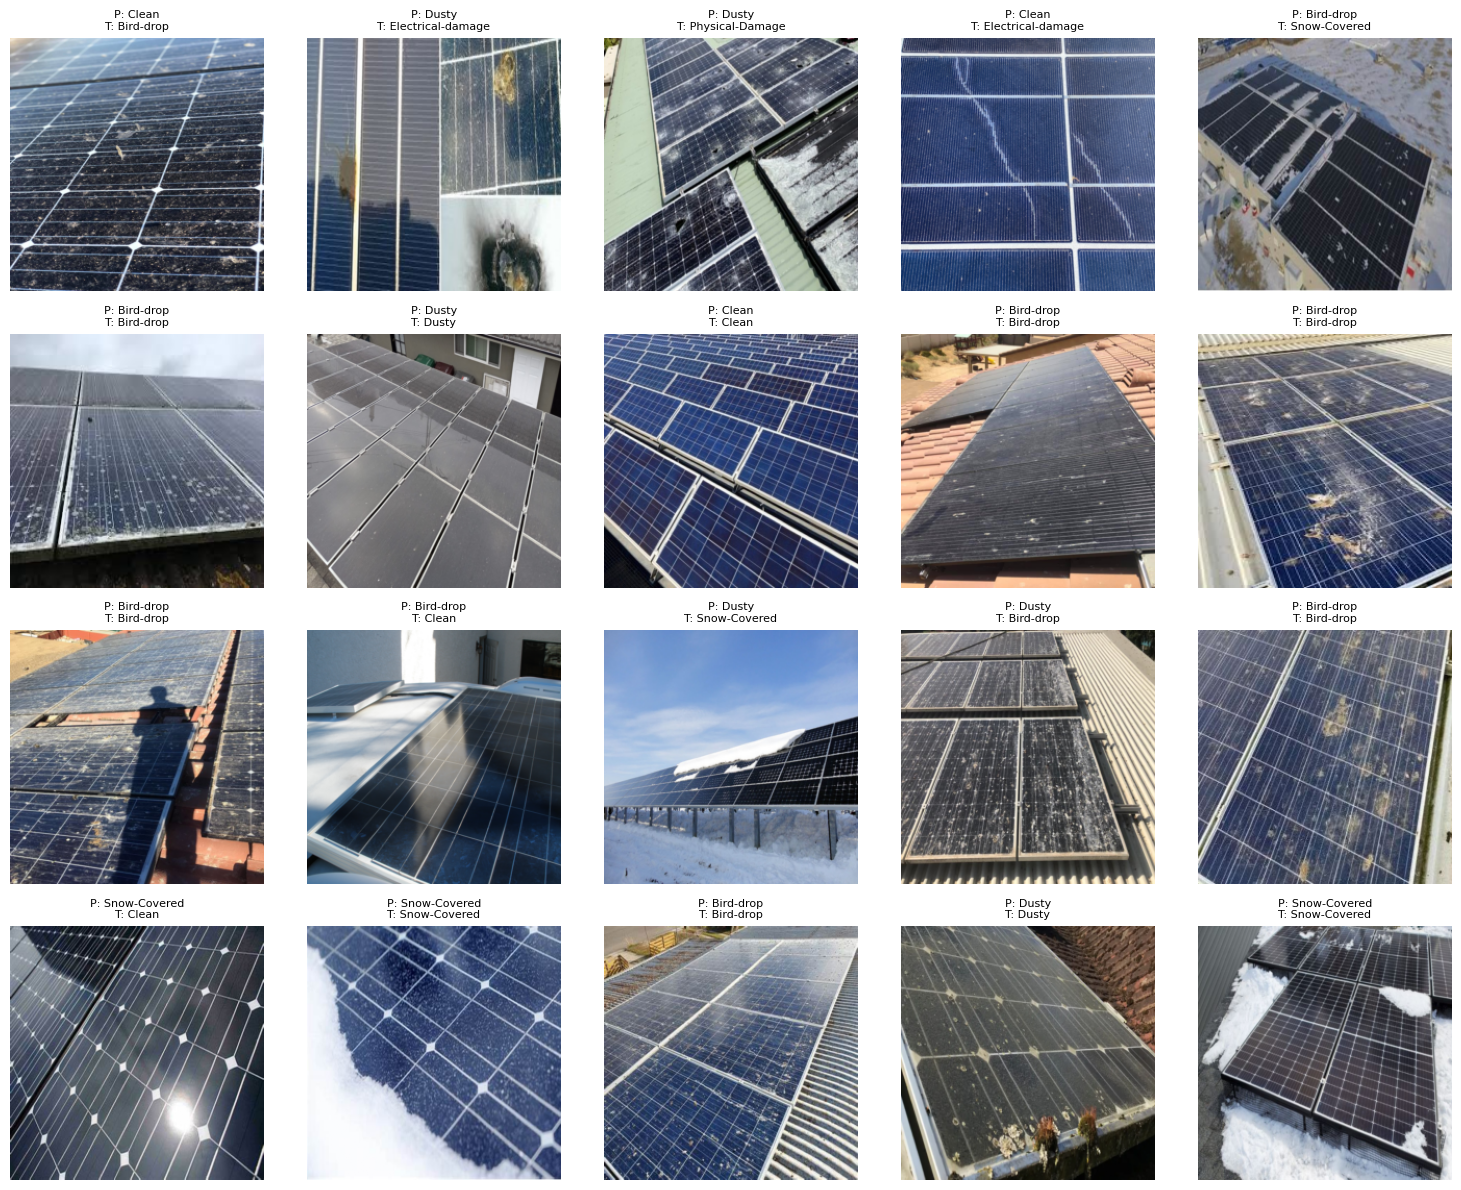

In [26]:
images, labels = next(iter(test_loader))
outputs = model(images.to(device))
_, preds = torch.max(outputs, 1)

plt.figure(figsize=(15, 12))
for i in range(20):
    ax = plt.subplot(4, 5, i + 1)
    img = images[i].cpu().permute(1, 2, 0).numpy()
    plt.imshow(img)
    plt.title(f"P: {class_names[preds[i]]}\nT: {class_names[labels[i]]}", fontsize=8)
    plt.axis('off')
plt.tight_layout()
plt.show()